# 1. Setup

In [1]:
from functools import reduce
from matplotlib_scalebar.scalebar import ScaleBar
from shapely.geometry import Polygon

from utils import *

# 2. Load data

## 2.1. Zones

In [2]:
state_list = (pd.read_csv('../data/zones/state_codes.csv')
              .sort_values('fips').head(51).pipe(lambda df: df[
                  ~df['name'].isin(['Alaska', 'Hawaii'])])).disp()

49 rows x 3 cols; Memory: 0.0 MiB


name      code     fips
   <object>  <object>  <int64>
0   Alabama        AL        1

In [3]:
us_counties = (gpd.read_parquet('../data/zones/us/county_trim.parquet')
               .rename(columns=D(geoid='cnty', name='county'))
               [['cnty', 'county', 'geometry']].set_crs(CRS_M)).disp()

3,108 rows x 3 cols; Memory: 0.4 MiB; CRS: EPSG:3857


cnty    county                                           geometry
   <object>  <object>                                         <geometry>
0     01001   Autauga  POLYGON ((-9624353.111696 3816718.739514, -962...

In [4]:
us_states = gpd.read_parquet('../data/zones/us/state_trim.parquet').set_crs(CRS_M).disp(0)

49 rows x 2 cols; Memory: 0.0 MiB; CRS: EPSG:3857


geoid    geometry
  <object>  <geometry>

## 2.2. Accessibility

### 2.2.1. Opportunities

In [5]:
opport = pd.read_parquet('../data/opportunities.parquet').disp()

1,389,776 rows x 4 cols; Memory: 47.6 MiB


geoid        kind   opport is_work
     <category>  <category>  <int32>  <bool>
0  010010201001       total      124    True

### 2.2.2. Impedance function parameters

In [6]:
imped_params = (
    pd.read_csv('../data/nhts/fitted-params-power-exponential.csv')
    .query('mode!="Transit" & measure=="Duration" & parameter!="r2"')
    .pivot_table('value', ['mode', 'purpose'], 'parameter').reset_index()
    .rename_axis(None, axis=1)
    .assign(mode=lambda df: df['mode'].str.lower(),
            purpose=lambda df: df.purpose.str.lower().str.replace(
                'social/recreational', 'leisure').str.replace(
                'other services', 'services'))).disp()

15 rows x 4 cols; Memory: 0.0 MiB


mode   purpose      alpha       beta
   <object>  <object>  <float64>  <float64>
0      bike  services   0.039438   1.023212

### 2.2.3. Processed data

In [7]:
xs_msa = pd.read_parquet('../data/access/msa_2020.parquet').disp()
xs_max_msa = pd.read_parquet('../data/access/max_msa_2020.parquet').disp(0)
xs_st = pd.read_parquet('../data/access/state_2020.parquet').disp(0)
xs_max_st = pd.read_parquet('../data/access/max_state_2020.parquet').disp(0)

12,956,475 rows x 7 cols; Memory: 172.8 MiB


region     purpose        kind        mode      thresh         geoid  \
   <category>  <category>  <category>  <category>  <category>    <category>   
0     seattle     nonwork     leisure        bike          45  530330001011   

       access  
    <float32>  
0  363.534302

12,661,467 rows x 7 cols; Memory: 169.1 MiB


region     purpose        kind        mode      thresh       geoid  \
  <category>  <category>  <category>  <category>  <category>  <category>   

     access  
  <float32>

1,663,319 rows x 7 cols; Memory: 44.3 MiB


region     purpose        kind        mode      thresh       geoid  \
  <category>  <category>  <category>  <category>  <category>  <category>   

     access  
  <float32>

1,663,207 rows x 7 cols; Memory: 44.3 MiB


region     purpose        kind        mode      thresh       geoid  \
  <category>  <category>  <category>  <category>  <category>  <category>   

     access  
  <float32>

# 3. Visualize

## 3.1. Jobs by county in the US

In [8]:
def fig_jobs_lodes(counties=us_counties, states=us_states, size=(15, 6), dpi=150):
    _, axes = plt.subplots(1, 2, figsize=size, dpi=dpi)
    df = pd.read_parquet('../data/lehd/wac_2021.parquet')
    df['geoid'] = df.geoid.str[:5]
    df = df.groupby('geoid').sum().reset_index()
    df['ratio'] = df['low_earn'] / df['high_earn']
    df = counties.merge(df, left_on='cnty', right_on='geoid')
    ax = pplot(axes[0], axoff=1)
    df.plot(ax=ax, column='total', cmap='bone_r', legend=True, vmax=2e5,
            legend_kwds=D(shrink=0.5, label='Total jobs available',
                          orientation='horizontal', pad=0, extend='max',
                          format=mpl.ticker.EngFormatter()))
    states.plot(ax=ax, fc='none', ec='k', lw=1.5)
    ax = pplot(axes[1], axoff=1)
    df.plot(ax=ax, column='ratio', cmap='RdYlGn_r', legend=True, vmin=0, vmax=1,
            legend_kwds=D(shrink=0.5, orientation='horizontal', pad=0, extend='max',
                          label='Ratio of low-earnings to high-earnings jobs'))
    states.plot(ax=ax, fc='none', ec='k', lw=1.5)
    plt.tight_layout()

# fig_jobs_lodes(dpi=250) # t=0:09

## 3.2. Accessibility heatmap

In [9]:
chi_cnty = ('Cook', 'DuPage')
nyc_cnty = ('New York', 'Bronx', 'Queens', 'Kings', 'Richmond')
wash_cnty = ('District of Columbia', 'Arlington', 'Alexandria')

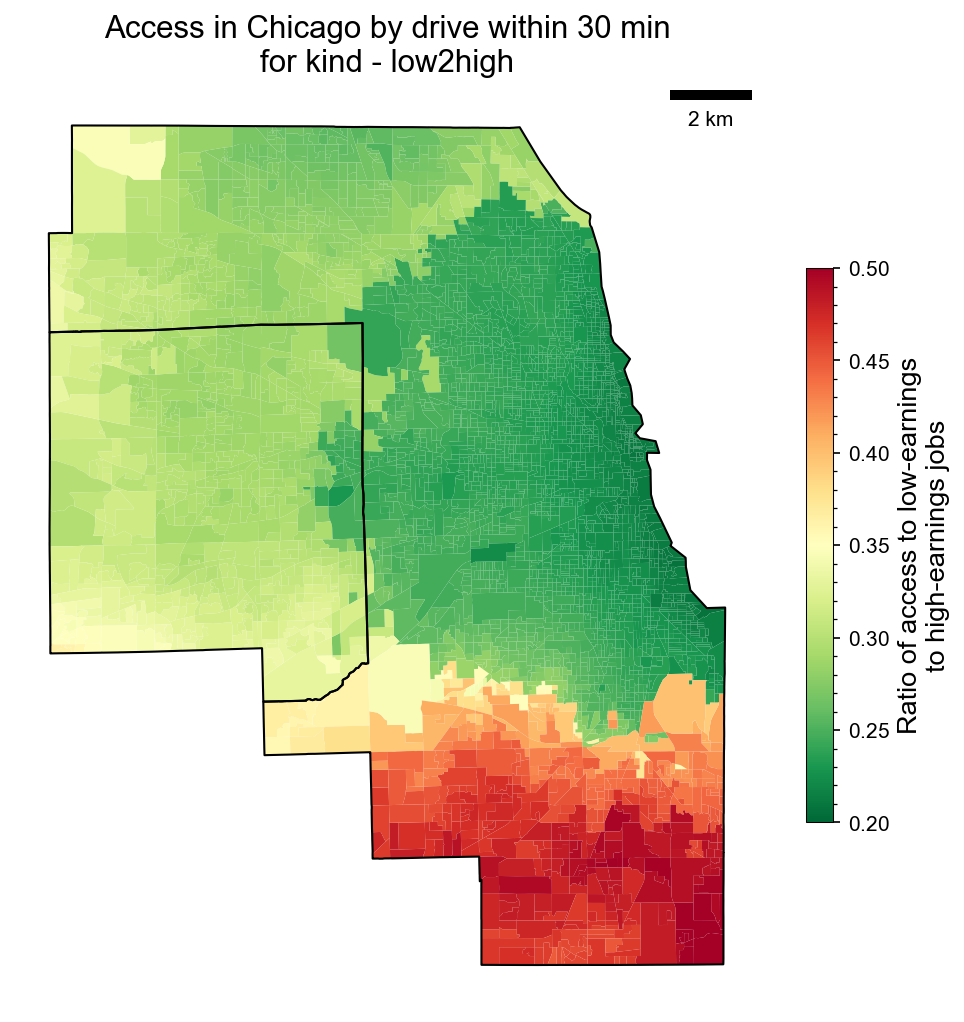

In [10]:
def plot_access_map(level, region, kind, mode, thresh, 
                    vmin=0, vmax=None, filt_counties=[], counties=us_counties,
                    size=(8, 8), dpi=150, cmap='gnuplot', save=False, show=True):
    xs = pd.read_parquet(f'../data/access/{level}_2020.parquet', filters=[
        ('region', '==', region), ('mode', '==', mode), ('thresh', '==', str(thresh))])
    if kind == 'low2high':
        low = xs[xs.kind == 'low_earn'].set_index('geoid')['access'].rename('low')
        high = xs[xs.kind == 'high_earn'].set_index('geoid')['access'].rename('high')
        xs = (low / high).rename('access').reset_index()
    elif kind == 'essential':
        ess = xs[xs.kind.isin(['shopping', 'services'])]
        ess = ess.astype(D(geoid=str)).groupby('geoid')['access'].mean()
        overall = xs[xs.kind == 'overall'].set_index('geoid')['access']
        xs = ((ess / overall).rename('access') * 100).reset_index()
    else:
        xs = xs[xs.kind == kind][['geoid', 'access']].reset_index(drop=1)
    bg = gpd.read_parquet(f'../data/zones/{level}_2020.parquet', filters=[
        ('scale', '==', 'bg'), ('region', '==', region)]).to_crs(CRS_M)
    bg['cnty'] = bg.geoid.str[:5]
    bg = bg.merge(counties[['cnty', 'county']])
    if filt_counties:
        bg = bg[bg.county.isin(filt_counties)]
    cnty = counties[counties.cnty.isin(bg.cnty.unique())]
    xs = bg[['geoid', 'geometry']].merge(xs, on='geoid')
    title = 'Access in {} by {} within {} min\nfor kind - {}'.format(
        region.title().replace('-', ' '), mode, thresh, kind)
    ax = pplot(size=size, dpi=dpi, axoff=1, title=title)
    cmap = 'RdYlGn_r' if kind == 'low2high' or kind == 'essential' else cmap
    if kind == 'low2high': label = 'Ratio of access to low-earnings\nto high-earnings jobs'
    elif kind == 'essential': label = 'Percent of overall accessibility\ncovered by essentials'
    else: label = 'Accessibility (no. of opportunities)'
    xs.plot(ax=ax, column='access', vmin=vmin, vmax=vmax, legend=True,
            cmap=cmap, legend_kwds=D(shrink=0.6, label=label))
    cnty.to_crs(CRS_M).plot(ax=ax, fc='none', ec='k', lw=1)
    ax.add_artist(ScaleBar(0.2))
    if save: imsave(title, root='../fig/access', dpi=300)
    if not show: plt.close()

# x = plot_access_map('msa', 'indianapolis', 'essential', 'drive', 30); x
x = plot_access_map('msa', 'chicago', 'low2high', 'drive', 30, 0.2, 0.5, chi_cnty); x

## 3.3. By purpose

### 3.3.1. Distributions

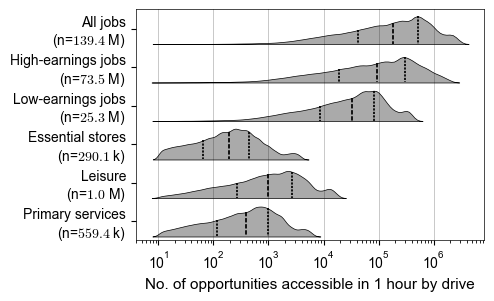

In [11]:
def plot_access_by_purpose(xs=xs_st, opport=opport, size=(4.5, 3), dpi=100):
    ax = pplot(size=size, dpi=dpi, xlog=1)
    purposes = D(total='All jobs', high_earn='High-earnings jobs', 
                 low_earn='Low-earnings jobs', shopping='Essential stores',
                 leisure='Leisure', services='Primary services')
    opport = (opport.groupby('kind')['opport'].sum().reset_index()
              .assign(purpose=lambda df: df.kind.map(purposes))
              .dropna().set_index('purpose').loc[list(purposes.values())]
              .reset_index().rename_axis('pid').reset_index())
    opport['purpose'] = ['{}\n(n={})'.format(
        r.purpose, mpl.ticker.EngFormatter(places=1)(r.opport)) 
                         for _, r in opport.iterrows()]
    xs = xs[['kind', 'access', 'geoid']].query('access > 10')
    xs = xs.merge(opport, on='kind').sort_values('pid').astype(D(purpose=CAT))
    xs.purpose = pd.Categorical(xs.purpose, categories=opport.purpose)
    ax = sns.violinplot(xs, y='purpose', x='access', hue=True,
                        hue_order=[True, False], split=True,
                        palette=sns.color_palette(['#aaa', 'w']),
                        inner='quart', legend=False, edgecolor='k')
    ax.set_xlabel('No. of opportunities accessible in 1 hour by drive', fontsize=11)
    ax.set_ylabel(''); ax.grid(color='k', alpha=0.3, axis='x')
    ax.tick_params(axis='y', which='minor', width=0)
    for x in ax.collections:
        x.set_linewidth(0.5)
    ax.patch.set_alpha(0)

plot_access_by_purpose(dpi=100) # t=0:07

### 3.3.2. Map (USA)

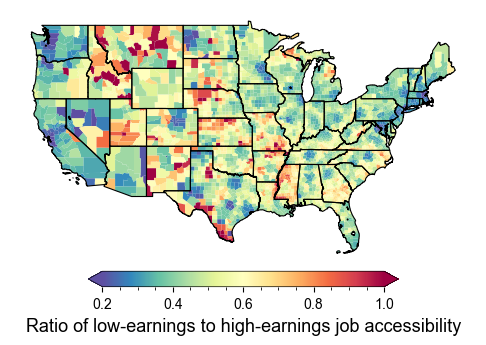

In [12]:
def plot_access_by_purpose(xs=xs_st, counties=us_counties, 
                           states=us_states, size=(10, 4), dpi=100):
    ax = pplot(size=size, dpi=dpi, axoff=1)
    xs = xs.assign(cnty=xs.geoid.str[:5]).copy()
    idx18 = xs[(xs.region.isin(['arkansas', 'mississippi'])) 
               & (xs.kind == 'high_earn')].index
    xs.loc[idx18, 'access'] *= 1.3
    xs = xs[xs.kind.isin(['low_earn', 'high_earn'])].copy()
    popu = (pd.read_parquet('../data/ses/acs_2021.parquet')
            .query('scale=="bg"')[['geoid', 'popu']])
    xs = xs.merge(popu)
    xs['access'] *= xs.popu
    xs = (xs.astype(D(kind=str)).groupby(['kind', 'cnty'])
          [['access', 'popu']].sum().reset_index())
    xs = xs.pivot_table('access', 'cnty', 'kind')
    xs['ratio'] = xs.low_earn / xs.high_earn
    xs = counties.merge(xs, on='cnty')
    label = 'Ratio of low-earnings to high-earnings job accessibility'
    xs.plot(ax=ax, column='ratio', cmap='Spectral_r', legend=True, legend_kwds=D(
        shrink=0.4, orientation='horizontal', label=label, pad=0.02, extend='both'), 
            vmin=0.2, vmax=1)
    states.plot(ax=ax, fc='none', ec='k', lw=0.8)

plot_access_by_purpose(dpi=100) # t=0:03

## 3.4. Flat cutoff vs decay

In [13]:
def get_flat_vs_decay(level, rgn, kind, mode, thresh, 
                      opport=opport, params=imped_params):
    purpose = 'work' if kind in ['total', 'low_earn', 'high_earn'] else kind
    params = params.query(f'mode=="{mode}" & purpose=="{purpose}"')
    alpha, beta = params.iloc[0].alpha, params.iloc[0].beta
    tt = pd.read_parquet('../data/osrm/{}/{}/bg_{}_2020.parquet'
                         .format(level, rgn, mode), filters=[
                             ('duration', '<=', thresh * 60)])
    tt['decay'] = np.exp(-alpha * (tt.duration / 60) ** beta)
    df = opport.query(f'kind=="{kind}"')[['geoid', 'opport']]
    wt = tt.assign(flat=1).merge(df, left_on='trg_geoid', right_on='geoid')
    for col in ['flat', 'decay']: wt[col] *= wt['opport']
    xs = (wt.groupby('src_geoid')[['flat', 'decay']].sum()
          .rename_axis('geoid').reset_index())
    xs['pct_increase'] = (xs.flat / xs.decay - 1) * 100
    return xs

# t=0:29
chi_flat_vs_decay = pd.concat([
    get_flat_vs_decay('msa', 'chicago', 'total', 'drive', t)
    .assign(thresh=t) for t in tqdm([15, 30, 45, 60, 90])
]).dropna().disp()

  0%|          | 0/5 [00:00<?, ?it/s]

33,614 rows x 5 cols; Memory: 2.0 MiB


geoid     flat          decay pct_increase   thresh
     <category>  <int64>      <float64>    <float64>  <int64>
0  170310101001   237098  188047.383645    26.084179       15

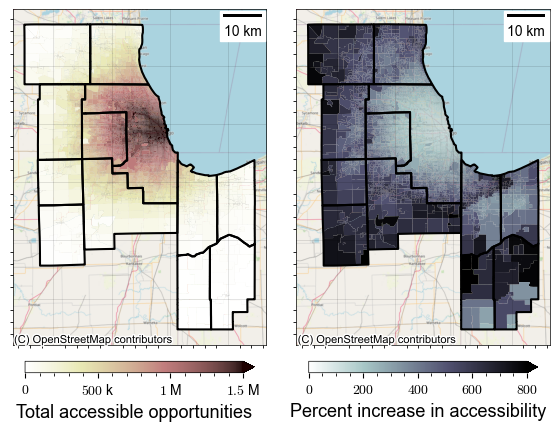

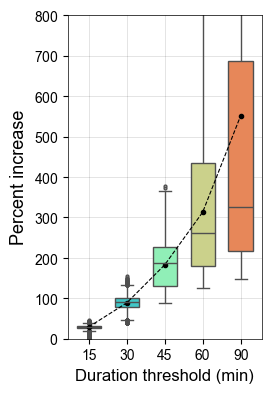

In [14]:
def plot_flat_vs_decay(xs=chi_flat_vs_decay, dpi=100):
    bg = gpd.read_parquet('../data/zones/msa_2020.parquet',
                          filters=[('region', '==', 'chicago'), ('scale', '==', 'bg')],
                          columns=['geoid', 'geometry']).to_crs(CRS_M)
    bg['cnty'] = bg.geoid.str[:5]
    bg = bg.merge(us_counties[['cnty', 'county']])
    bg = bg[bg.county != 'DeKalb']
    cnty = bg[['cnty', 'geometry']].dissolve('cnty').reset_index()
    xs = bg[['geoid', 'geometry']].merge(xs, on='geoid')
    xs60 = xs.query('thresh==60')
    ## Panels A & B
    fig, axes = plt.subplots(1, 2, figsize=(6, 4.5), dpi=dpi)
    for i, (col, cmap, vmax, label) in enumerate([
            ('decay', 'pink_r', 1.5e6, 'Total accessible opportunities'),
            ('pct_increase', 'bone_r', 800, 'Percent increase in accessibility')]):
        ax = xs60.plot(ax=axes[i], column=col, cmap=cmap, legend=True,
                       vmin=0, vmax=vmax, legend_kwds=D(
                           label=label, format=mpl.ticker.EngFormatter(), pad=0.04,
                           shrink=0.8, orientation='horizontal', extend='max'))
        ax.tick_params(left=0, right=0, labelleft=0, labelbottom=0, bottom=0)
        ax.add_artist(ScaleBar(0.3))
        cnty.plot(ax=ax, fc='none', ec='k', lw=1.5)
        ctx.add_basemap(ax=ax, crs=CRS_M, source=BASEMAP)
    fig.subplots_adjust(wspace=0)
    fig.tight_layout()
    ## Panel C
    ax = pplot(size=(2.5, 4.2), dpi=dpi, ylim=(0, 800))
    ax = sns.boxplot(xs, ax=ax, x='thresh', y='pct_increase', 
                     palette='rainbow', fliersize=2, gap=0.2)
    avg_xs = xs.groupby('thresh')['pct_increase'].mean().reset_index(drop=1)
    avg_xs.plot(ax=ax, ls='--', lw=0.8, marker='.', color='k')
    ax.set_xlabel('Duration threshold (min)', fontsize=12)
    ax.set_ylabel('Percent increase')
    ax.minorticks_off()

plot_flat_vs_decay(dpi=100) # t=0:09

## 3.5. Access efficiency

In [15]:
test_msas = (
    ('houston', ['Harris']),
    ('new-york', ['New York', 'Bronx', 'Queens', 'Kings', 'Richmond']),
    ('chicago', ['Cook', 'DuPage']),
    # ('indianapolis', ['Marion']),
    # ('minneapolis', ['Hennepin', 'Ramsey']),
    # ('columbus', ['Franklin'])    
)

In [16]:
def plot_efficiency(level, rgn, counties=[], thresh=60, mode='drive', 
                    kind='total', us_counties=us_counties,
                    size=(8, 8), dpi=150, cmap='gnuplot',
                    vmin=None, vmax=None, alpha=1):
    bg = gpd.read_parquet(f'../data/zones/{level}_2020.parquet', filters=[
        ('scale', '==', 'bg'), ('region', '==', rgn)
    ], columns=['geoid', 'geometry']).to_crs(CRS_M)
    bg['cnty'] = bg.geoid.str[:5]
    bg = bg.merge(us_counties[['cnty', 'county']])
    if counties: bg = bg[bg.county.isin(counties)]
    cnty = us_counties[us_counties.cnty.isin(bg.cnty)]
    xs = pd.merge(*[
        pd.read_parquet(f'../data/access/{label}{level}_2020.parquet', filters=[
            ('region', '==', rgn), ('thresh', '==', str(thresh)),
            ('mode', '==', mode), ('kind', '==', kind)],
                        columns=['geoid', 'access'])
        .rename(columns=D(access=xs_kind))
        for xs_kind, label in [('observed', ''), ('maximum', 'max_')]
    ], on='geoid').assign(pct=lambda df: df['observed'] / df['maximum'] * 100)
    xs = bg.merge(xs, on='geoid')
    ax = pplot(size=size, dpi=dpi, axoff=1)
    xs.plot(ax=ax, column='pct', legend=True, cmap=cmap, vmin=vmin, vmax=vmax,
            legend_kwds=D(shrink=0.7, label='Efficiency (\%)'), alpha=alpha)
    cnty.plot(ax=ax, fc='none', ec='k', lw=1.5)
    ctx.add_basemap(ax=ax, crs=CRS_M, source=BASEMAP)
    ax.add_artist(ScaleBar(0.3))

In [17]:
# x = plot_efficiency('msa', 'indianapolis', ['Marion'], 30, alpha=0.75, vmin=20, vmax=50, cmap='Spectral'); x

In [18]:
# plot_efficiency('msa', 'chicago', ['Lake', 'Porter', 'Jasper', 'Newton'], 30, alpha=0.75, vmin=0, vmax=30, cmap='Spectral')

In [19]:
# plot_efficiency('state', 'indiana', [], 60, vmin=0, vmax=50)

### 3.5.1. Test cities

  0%|          | 0/3 [00:00<?, ?it/s]

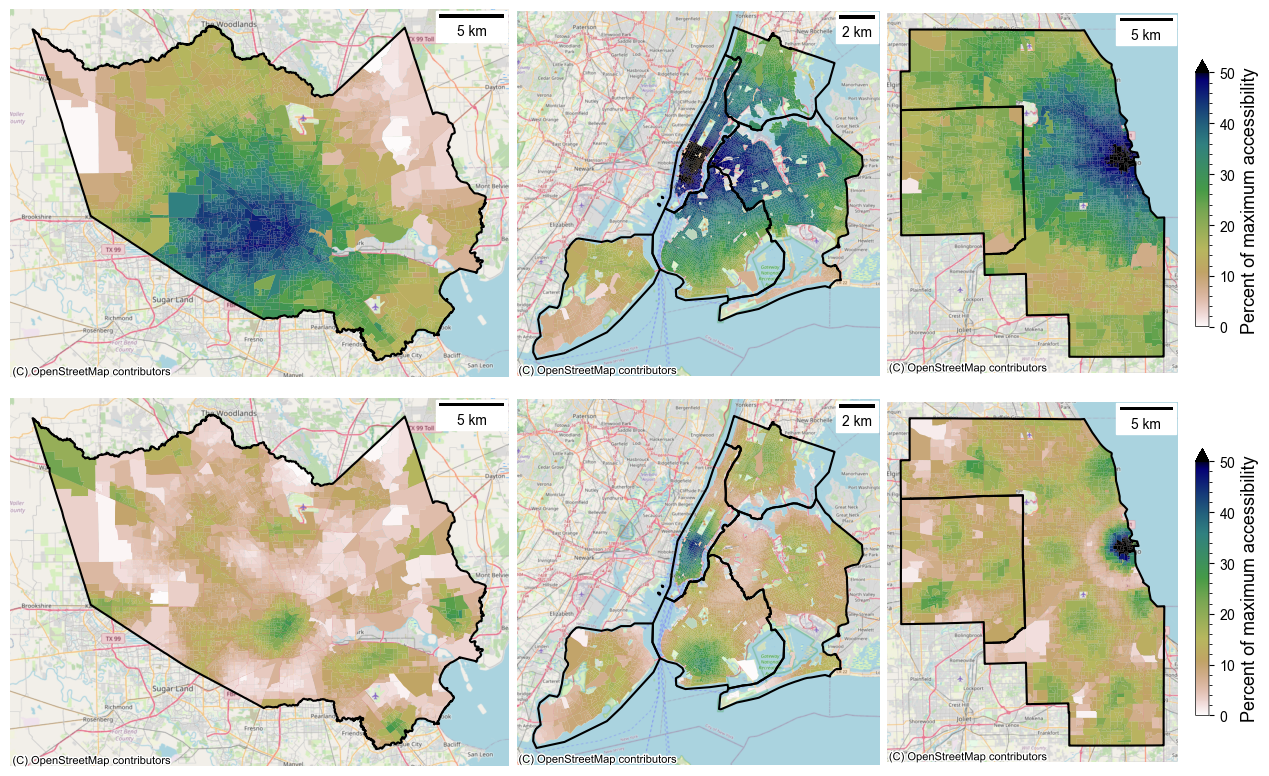

In [20]:
def plot_access_efficiency_map(msas=test_msas, obs_xs=xs_msa, max_xs=xs_max_msa,
                               thresh=30, vmin=0, vmax=50, us_counties=us_counties,
                               widths=(1.1, 0.8, 0.8), size=(16, 10), dpi=100, cmap='gnuplot'):
    fig, axes = plt.subplots(2, 3, figsize=size, dpi=dpi, gridspec_kw=D(width_ratios=widths))
    for j, (rgn, counties) in enumerate(tqdm(msas)):
        zones = gpd.read_parquet('../data/zones/msa_2020.parquet', filters=[
            ('scale', '==', 'bg'), ('region', '==', rgn), ('aland', '>', 0)],
                                 columns=['geoid', 'geometry'])
        zones['cnty'] = zones.geoid.str[:5]
        zones = zones.merge(us_counties[['cnty', 'county']], on='cnty')
        zones = zones[zones.county.isin(counties)].to_crs(CRS_M)
        cnty = us_counties.merge(zones[['cnty']].drop_duplicates())
        popu = pd.read_parquet('../data/ses/acs_2021.parquet', filters=[
            ('scale', '==', 'bg')], columns=['geoid', 'popu'])
        zones = zones.merge(popu, on='geoid')
        zones['popu_wt'] = zones['popu'] / zones['popu'].sum()
        for i, mode in enumerate(['drive', 'bike']):
            xs = pd.merge(*[
                df.query(f'region=="{rgn}" & thresh=="{thresh}" & '
                         f'kind=="total" & mode=="{mode}"')
                [['geoid', 'access']].rename(columns=D(access=xs_kind))
                for xs_kind, df in [('observed', obs_xs), ('maximum', max_xs)]
            ], on='geoid')
            xs['pct'] = xs['observed'] / xs['maximum'] * 100
            xs = zones.merge(xs[['geoid', 'pct']])
            ax = pplot(axes[i, j], axoff=1)
            xs.plot(ax=ax, column='pct', legend=j == 2, cmap=cmap, 
                    vmin=vmin, vmax=vmax, legend_kwds=D(
                        shrink=0.7, extend='max', label='Percent of maximum accessibility'))
            cnty.plot(ax=ax, fc='none', ec='k', lw=1.5)
            ctx.add_basemap(ax=ax, crs=CRS_M, source=BASEMAP)
            ax.add_artist(ScaleBar(0.3))
    fig.subplots_adjust(wspace=0.02, hspace=0.02)
    
plot_access_efficiency_map(dpi=100, cmap='gist_earth_r') # t=0:23

  0%|          | 0/3 [00:00<?, ?it/s]

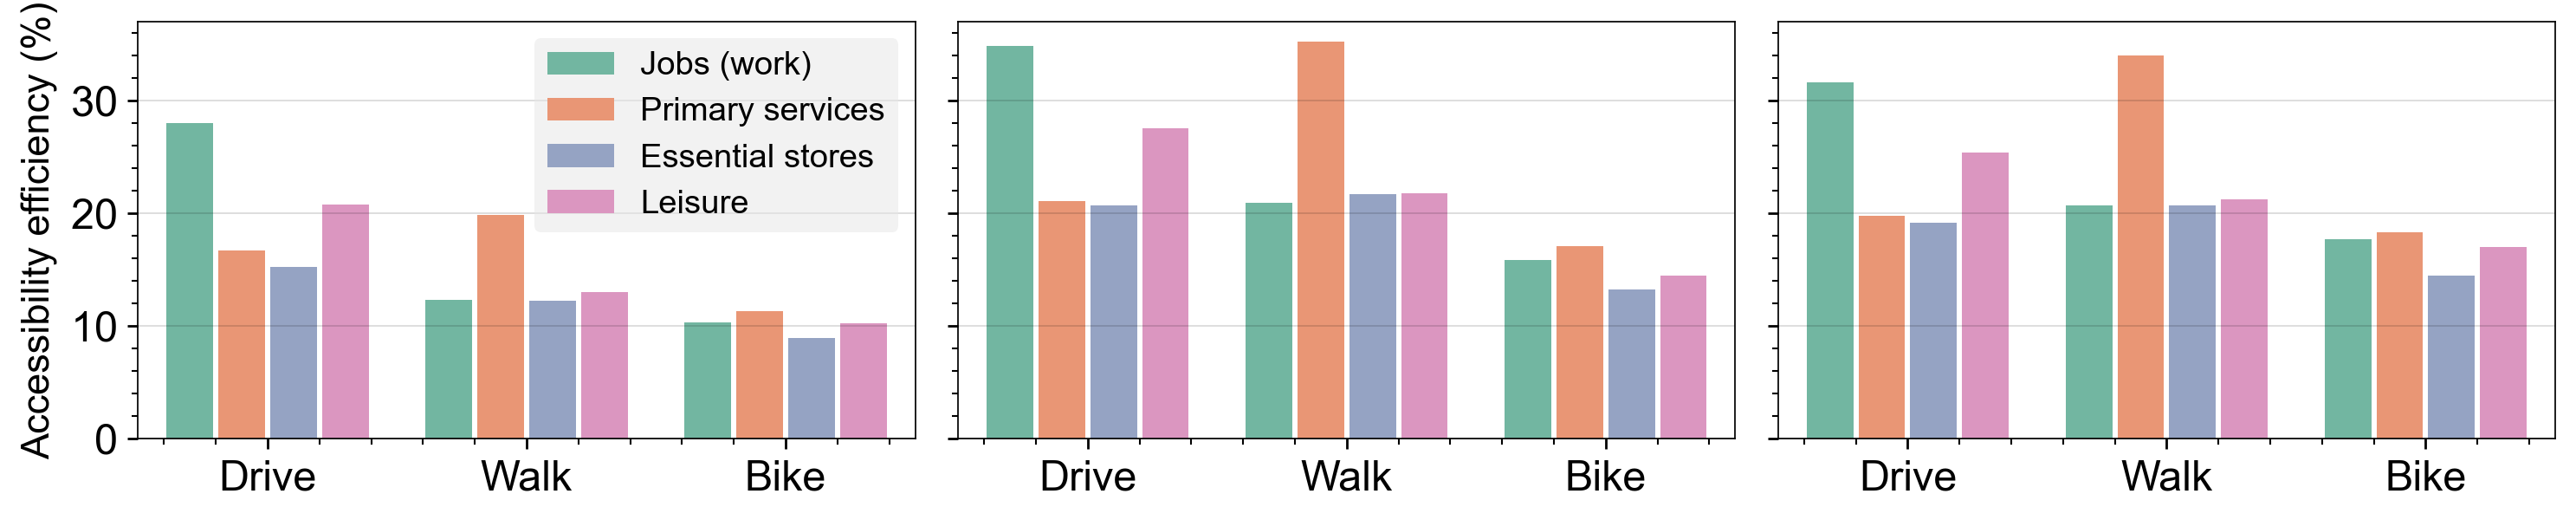

In [21]:
def plot_access_efficiency_bar(msas=test_msas, obs_xs=xs_msa, max_xs=xs_max_msa,
                               us_counties=us_counties, size=(12, 2.5), dpi=100):
    purposes = D(total='Jobs (work)', services='Primary services',
                 shopping='Essential stores', leisure='Leisure')
    _, axes = plt.subplots(1, 3, figsize=size, dpi=dpi, sharey=True)
    for j, (rgn, filt_counties) in enumerate(tqdm(msas)):
        zones = gpd.read_parquet('../data/zones/msa_2020.parquet', filters=[
            ('scale', '==', 'bg'), ('region', '==', rgn), ('aland', '>', 0)],
                                 columns=['geoid', 'geometry'])
        zones['cnty'] = zones.geoid.str[:5]
        zones = zones.merge(us_counties[['cnty', 'county']], on='cnty')
        zones = zones[zones.county.isin(filt_counties)].to_crs(CRS_M)
        popu = pd.read_parquet('../data/ses/acs_2021.parquet', filters=[
            ('scale', '==', 'bg')], columns=['geoid', 'popu'])
        zones = zones.merge(popu, on='geoid')
        zones['popu_wt'] = zones['popu'] / zones['popu'].sum()
        xs = pd.merge(*[df.query(f'region=="{rgn}" & thresh=="30"')
                        .rename(columns=D(access=xs_kind))
                        [['kind', 'mode', 'geoid', xs_kind]]
                        for xs_kind, df in [('observed', obs_xs), ('maximum', max_xs)]
                        ], on=('kind', 'mode', 'geoid'))
        xs = zones[['geoid', 'popu_wt', 'geometry']].merge(xs, on='geoid')
        xs = xs.assign(kind=xs.kind.map(purposes), mode=xs['mode'].str.title()).dropna()
        xs['observed'] *= xs['popu_wt']
        xs['maximum'] *= xs['popu_wt']
        effic = xs.groupby(['kind', 'mode'])[['observed', 'maximum']].sum()
        effic = (effic['observed'] / effic['maximum'] * 100).rename('eta').reset_index()
        sns.barplot(effic, x='mode', y='eta', hue='kind', ax=axes[j],
                    palette='Set2', legend=j == 0, gap=0.1, alpha=1, 
                    order=['Drive', 'Walk', 'Bike'], hue_order=purposes.values())
        ax = pplot(axes[j], xlab='', ylab='Accessibility efficiency (%)' if j == 0 else '')
        ax.tick_params(labelsize=14)
        leg = ax.get_legend()
        if leg: leg.set_title('')
        plt.tight_layout()

plot_access_efficiency_bar(dpi=250) # t=0:09

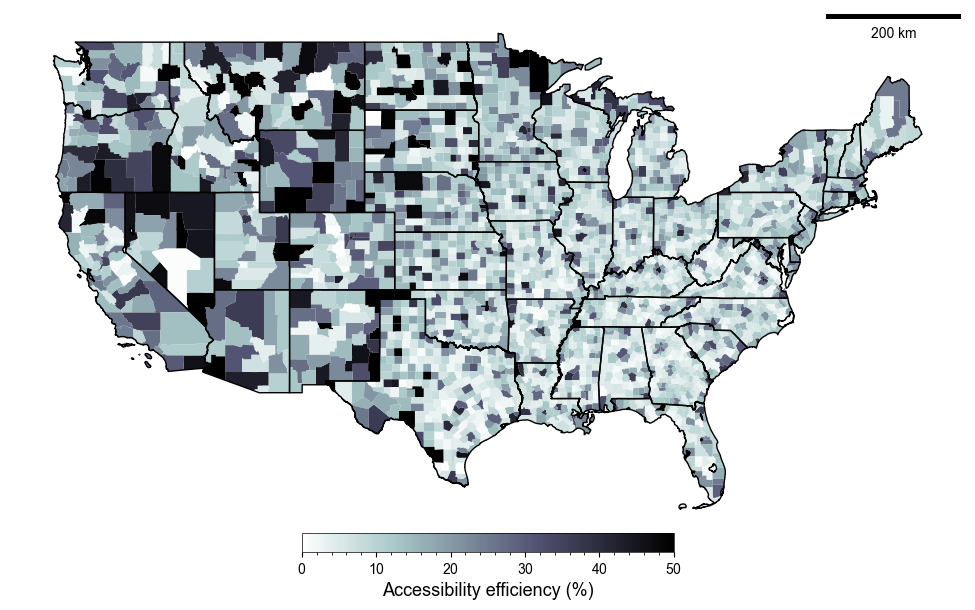

In [22]:
def plot_access_efficiency_map_us(obs_xs=xs_st, max_xs=xs_max_st, kind='total',
                                  vmin=0, vmax=50, size=(16, 8), dpi=100,
                                  counties=us_counties, states=us_states):
    obs_xs = (obs_xs.query(f'kind=="{kind}"')[['geoid', 'access']]
              .rename(columns=D(access='obs')))
    max_xs = (max_xs.query(f'kind=="{kind}"')[['geoid', 'access']]
              .rename(columns=D(access='max')))
    xs = pd.merge(obs_xs, max_xs, on='geoid')
    popu = pd.read_parquet('../data/ses/acs_2021.parquet', filters=[
        ('scale', '==', 'bg')], columns=['geoid', 'popu'])
    xs = xs.merge(popu, on='geoid')
    xs.geoid = xs.geoid.str[:5]
    for col in ['obs', 'max']: xs[col] *= xs['popu']
    xs = xs.groupby('geoid')[['obs', 'max']].sum().reset_index()
    xs['pct'] = xs['obs'] / xs['max'] * 100
    xs = counties.merge(xs, left_on='cnty', right_on='geoid')
    ax = pplot(size=size, dpi=dpi, axoff=1)
    xs.plot(ax=ax, column='pct', vmin=vmin, vmax=vmax, cmap='bone_r', 
            legend=True, legend_kwds=D(
                orientation='horizontal', shrink=0.3, pad=0,
                label='Accessibility efficiency (%)'))
    states.plot(ax=ax, fc='none', ec='k', lw=1)
    ax.add_artist(ScaleBar(0.2))

x = plot_access_efficiency_map_us(dpi=100); x # t=0:04

## 3.6. Opportunities equity

### 3.6.1. Regional zones of Cook County

In [23]:
bg_chi = gpd.read_parquet(f'../data/zones/msa_2020.parquet', filters=[
        ('scale', '==', 'bg'), ('region', '==', 'chicago')
        ], columns=['geoid', 'geometry']).to_crs(CRS_M)
bg_cook = bg_chi[bg_chi.geoid.str[:5] == '17031'].disp()

4,001 rows x 2 cols; Memory: 0.3 MiB; CRS: EPSG:3857


geoid                                           geometry
       <object>                                         <geometry>
0  170310101001  POLYGON ((-9759589.595086 5164433.147558, -975...

In [24]:
bound_cook = bg_cook.dissolve()

### 3.6.2. Regional zones of South Chicago

In [25]:
# zones of South Chicago
bg_schi = gpd.read_file('../data/ses/high_sedi_rgn_cook.gpkg').drop(columns='sedi').disp(0)

1,258 rows x 2 cols; Memory: 0.1 MiB; CRS: EPSG:3857


geoid    geometry
  <object>  <geometry>

In [26]:
poly = bg_schi.dissolve().geometry.iloc[0]
poly = reduce(lambda x, y: x.union(Polygon(y)), list(poly.interiors), poly)
bound_schi = Gdf(D(geometry=[poly]), crs=CRS_M)

### 3.6.3. SEDI values

In [27]:
def get_sedi(bgs, rank=True, cols=(
        'p_poc p_pov p_snglparent p_crowded p_lowedu p_renter '
        'p_noveh p_noinsur p_lowenglish p_disabled p_unemploy').split()):
    ses = pd.read_parquet('../data/ses/acs_2021.parquet')
    ses = ses[['geoid', 'popu'] + cols]
    ses = bgs[['geoid']].merge(ses, on='geoid').fillna(0)
    if rank:
        sedi = ses[cols].rank(pct=True).assign(geoid=ses.geoid)
    sedi['sedi'] = ses[cols].mean(axis=1).rank(pct=True)
    sedi = (bgs[['geoid', 'geometry']].merge(sedi[['geoid', 'sedi']])
            .merge(ses[['geoid', 'popu']]))
    return sedi

cols = 'p_pov p_poc p_unemploy p_lowedu p_noveh p_snglparent'.split()
sedi_cook = get_sedi(bg_cook, cols=cols).disp(0)
sedi_schi = get_sedi(bg_schi, cols=cols).disp(0)

3,992 rows x 4 cols; Memory: 0.4 MiB; CRS: EPSG:3857


geoid    geometry       sedi       popu
  <object>  <geometry>  <float64>  <float64>

1,258 rows x 4 cols; Memory: 0.1 MiB; CRS: EPSG:3857


geoid    geometry       sedi       popu
  <object>  <geometry>  <float64>  <float64>

### 3.6.4. Improvement potential gradient

In [28]:
def get_xs_gradient(sedi, level, rgn, kind, mode, thresh, popu_wt='popu', params=imped_params):
    assert popu_wt in ['popu', 'sedi']
    ses = sedi.assign(ses_wt=sedi.popu * sedi.sedi if popu_wt == 'sedi' else sedi.popu)
    ses['ses_wt'] /= ses['ses_wt'].sum()
    purpose = 'work' if kind in ['total', 'low_earn', 'high_earn'] else kind
    params = params.query(f'mode=="{mode}" & purpose=="{purpose}"')
    alpha, beta = params.iloc[0][['alpha', 'beta']]
    od = pd.read_parquet(f'../data/osrm/{level}/{rgn}/bg_{mode}_2020.parquet',
                         filters=[('duration', '<=', thresh * 60)])
    od = od.rename(columns=D(src_geoid='src', trg_geoid='trg'))
    od = od.merge(ses.geoid.rename('src')).merge(ses.geoid.rename('trg'))
    od = od.astype(D(src=CAT, trg=CAT)).drop(columns='distance')
    od['time_wt'] = np.exp(-alpha * (od.pop('duration') / 60) ** beta)
    grad = od.merge(ses[['geoid', 'ses_wt']].rename(columns=D(geoid='trg')))
    grad['weight'] = grad['time_wt'] * grad['ses_wt']
    grad = grad.groupby('src')['weight'].sum().rename_axis('geoid').reset_index()
    grad = ses[['geoid', 'geometry']].merge(grad, on='geoid')
    grad.weight = grad.weight.rank(pct=True)
    return grad

args = ('msa', 'chicago', 'shopping', 'drive', 30)
grad_cook_popu = get_xs_gradient(sedi_cook, *args, popu_wt='popu').disp() # t=0:09
grad_cook_sedi = get_xs_gradient(sedi_cook, *args, popu_wt='sedi') # t=0:09
grad_schi_popu = get_xs_gradient(sedi_schi, *args, popu_wt='popu') # t=0:04
grad_schi_sedi = get_xs_gradient(sedi_schi, *args, popu_wt='sedi') # t=0:04

3,992 rows x 3 cols; Memory: 0.3 MiB; CRS: EPSG:3857


geoid                                           geometry     weight
       <object>                                         <geometry>  <float64>
0  170310101001  POLYGON ((-9759589.595086 5164433.147558, -975...   0.429609

### 3.6.5. Difference in improvement potential

In [29]:
def get_grad_diff(df_popu, df_sedi):
    df_popu = df_popu.assign(popu=df_popu.weight.rank(pct=True))
    df_sedi = df_sedi.assign(sedi=df_sedi.weight.rank(pct=True))
    df = df_popu.merge(df_sedi[['geoid', 'sedi']], on='geoid')
    df['delta'] = df.sedi - df.popu
    return df

grad_cook_delta = get_grad_diff(grad_cook_popu, grad_cook_sedi).disp()
grad_schi_delta = get_grad_diff(grad_schi_popu, grad_schi_sedi)

3,992 rows x 6 cols; Memory: 0.4 MiB; CRS: EPSG:3857


geoid                                           geometry     weight  \
       <object>                                         <geometry>  <float64>   
0  170310101001  POLYGON ((-9759589.595086 5164433.147558, -975...   0.429609   

        popu       sedi      delta  
   <float64>  <float64>  <float64>  
0   0.429609   0.316633  -0.112976

### 3.6.6. Plot the improvement potential

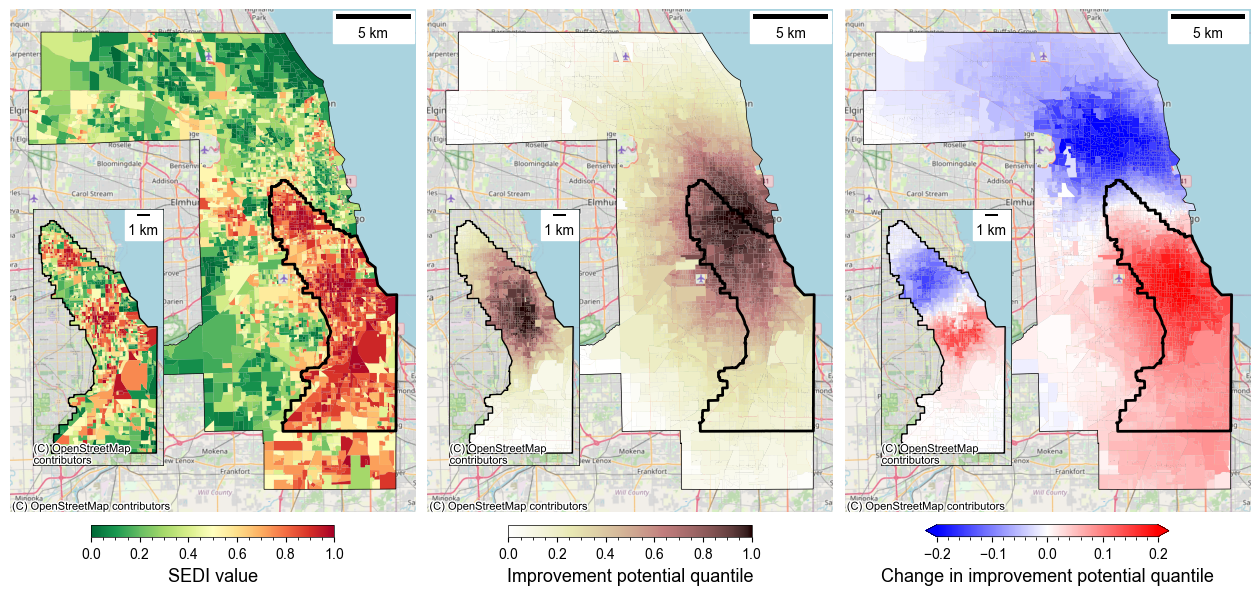

In [30]:
def fig_improvement_potential(size=(16, 8), dpi=250):
    fig, axes = plt.subplots(1, 3, figsize=size, dpi=dpi)
    ax1, ax2, ax3 = [pplot(ax, axoff=1) for ax in axes]
    
    def main_plot(ax, df, column, cmap, vmin, vmax, label, extend=None):
        df.plot(ax=ax, column=column, cmap=cmap, legend=True, 
                vmin=vmin, vmax=vmax, legend_kwds=D(
                    label=label, shrink=0.6, orientation='horizontal', 
                    pad=0.02, extend=extend))
        bound_cook.plot(ax=ax, fc='none', ec='k', lw=0.5)
        bound_schi.plot(ax=ax, fc='none', ec='k', lw=2)
        ctx.add_basemap(ax=ax, crs=CRS_M, source=BASEMAP)
        ax.add_artist(ScaleBar(0.3))
    main_plot(ax1, sedi_cook, 'sedi', 'RdYlGn_r', 0, 1, 'SEDI value')
    main_plot(ax2, grad_cook_sedi, 'weight', 'pink_r', 0, 1,
              label='Improvement potential quantile')
    main_plot(ax3, grad_cook_delta, 'delta', 'bwr', -0.2, 0.2,
              label='Change in improvement potential quantile', extend='both')
    
    def inset_plot(bbox, df, column, cmap, vmin, vmax, **kw):
        ax = fig.add_subplot(bbox)
        df.plot(ax=ax, column=column, cmap=cmap, vmin=vmin, vmax=vmax, **kw)
        bound_schi.plot(ax=ax, fc='none', ec='k', lw=1)
        ax.xaxis.set_tick_params(labelbottom=False)
        ax.yaxis.set_tick_params(labelleft=False)
        ax.set_xticks([]); ax.set_yticks([])
        ctx.add_basemap(ax=ax, crs=CRS_M, source=BASEMAP)
        ax.add_artist(ScaleBar(0.3))
    inset_plot([0.13, 0.3, 0.1, 0.32], sedi_schi, 'sedi', 'RdYlGn_r', 0, 1)
    inset_plot([0.39, 0.3, 0.1, 0.32], grad_schi_sedi, 'weight', 'pink_r', 0, 1)
    inset_plot([0.66, 0.3, 0.1, 0.32], grad_schi_delta, 'delta', 'bwr', -0.2, 0.2)
    fig.subplots_adjust(wspace=0.03)

fig_improvement_potential(dpi=100) # t=0:13